## Setting up Your Python Environment
per: https://blog.roboflow.com/how-to-use-segment-anything-model-sam/

In [47]:
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
!pip install torch torchvision

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pzam4yxu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pzam4yxu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [1]:
import geopandas as gpd
import numpy as np
import rasterio
from PIL import Image
from shapely.geometry import Polygon
import torch
from segment_anything import sam_model_registry

## Loading the Segment Anything Model

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # use cpu if no access to gpu
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="/home/jovyan/swe_forecasting_prod/notebooks/sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)

/srv/conda/envs/notebook/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

In [4]:
# Function to convert GeoTIFF to JPEG
def convert_geotiff_to_jpeg(geotiff_path, jpeg_path):
    with rasterio.open(geotiff_path) as src:
        # Read the image data
        band_data = src.read(1)  # Assuming single band image for SWE
        # img_array = np.interp(img_array, (img_array.min(), img_array.max()), (0, 255)).astype(np.uint8)

        # Step 2: Normalize the data to 0-1 for colormap application
        band_min, band_max = band_data.min(), band_data.max()
        normalized_band = (band_data - band_min) / (band_max - band_min)
        
        # Step 3: Apply a colormap
        colormap = cm.get_cmap('viridis')  # Choose a colormap (e.g., 'viridis', 'jet', 'plasma')
        colored_image = colormap(normalized_band)  # Apply colormap
        colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB and scale to 0-255
        
        # Step 4: Save the RGB image as JPEG
        jpeg_image = Image.fromarray(colored_image)
        jpeg_image.save(jpeg_path, 'JPEG')
        
        print("Single-band GeoTIFF has been successfully converted to an RGB JPEG image.")


        # # Convert to PIL Image
        # img = Image.fromarray(img_array)
        # img = img.convert('L')  # Convert to grayscale if needed

        # # Save as JPEG
        # img.save(jpeg_path)
        
# Paths to input and output files
geotiff_path = '/home/jovyan/shared-public/ml_swe_monitoring_prod/swe_predicted_2023-12-15_median_filtered.tif'
jpeg_path = '/home/jovyan/shared-public/ml_swe_monitoring_prod/swe_predicted_2023-12-15_median_filtered.jpg'
shapefile_path = '/home/jovyan/shared-public/ml_swe_monitoring_prod/swe_predicted_2023-12-15_median_filtered.shp'
    
# Convert GeoTIFF to JPEG
convert_geotiff_to_jpeg(geotiff_path, jpeg_path)


Single-band GeoTIFF has been successfully converted to an RGB JPEG image.


/tmp/ipykernel_2070/3245926074.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')  # Choose a colormap (e.g., 'viridis', 'jet', 'plasma')


## Automated Mask (Instance Segmentation) Generation with SAM

Processing tile 0 0


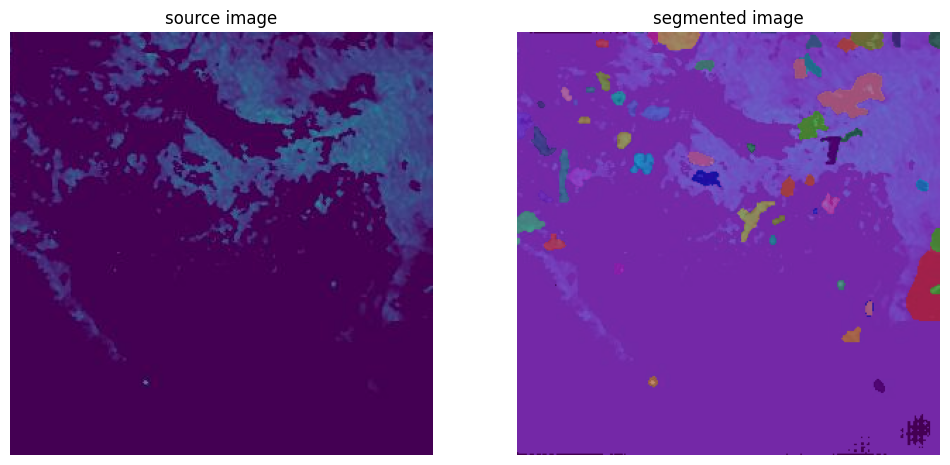

Processing tile 300 0


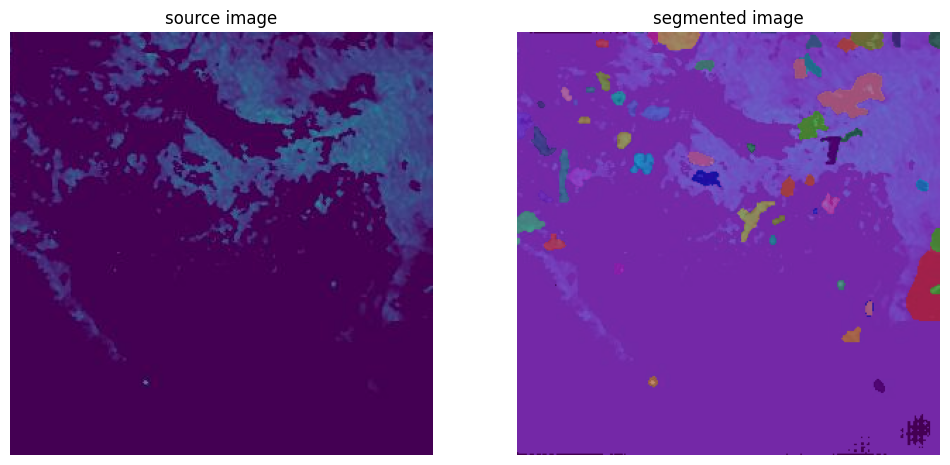

Processing tile 600 0


In [ ]:
import cv2
from segment_anything import SamAutomaticMaskGenerator
import supervision as sv


mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread(jpeg_path) # this is the jpeg of our swe prediction 

# Get image dimensions
height, width, _ = image_bgr.shape

# Define tile size
tile_size = 300
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
            

# Loop through the image and extract tiles
for y in range(0, height, tile_size):
    for x in range(0, width, tile_size):
        print(f"Processing tile {x} {y}")
        # Ensure the tile has the correct size (padding may be needed for edges)
        # Optionally pad the tile to ensure it has the correct size
        top_left_y = y * tile_size
        top_left_x = x * tile_size
        bottom_right_y = (y+1) * tile_size
        bottom_right_x = (x+1) * tile_size

        # Extract the tile from the image
        tile = image_bgr[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        image_rgb = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
        result = mask_generator.generate(image_rgb)
        
        detections = sv.Detections.from_sam(sam_result=result)
        
        annotated_image = mask_annotator.annotate(scene=tile.copy(), detections=detections)
        
        sv.plot_images_grid(
            images=[tile, annotated_image],
            grid_size=(1, 2),
            titles=['source image', 'segmented image']
        )
            

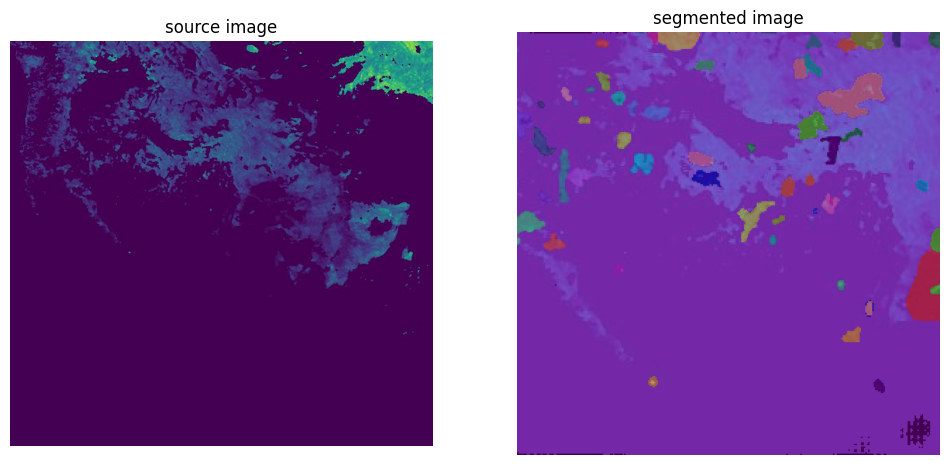